# Method 2 - Best Fresh Ideas

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Returns for Fresh Ideas

%store -r r

# Get Adjusted Quantities

qty_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='quantity',
                           aggfunc='sum')
qty_pivot = qty_pivot.mul(r.splits.reindex(qty_pivot.index), level=1).fillna(0)
qty_pivot = qty_pivot - qty_pivot.shift(1)
flat_qty = pd.melt(qty_pivot.reset_index(), id_vars='datadate', value_name='qty_change')
flat_qty = flat_qty[flat_qty['qty_change'] > 0]

# Get Pos Size Change

pos_size_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='target',
                                aggfunc='sum')
pos_size_pivot = pos_size_pivot - pos_size_pivot.shift(1)
flat_pos_size = pd.melt(pos_size_pivot.reset_index(), id_vars='datadate', value_name='size_change')
flat_pos_size = flat_pos_size[flat_pos_size['size_change'] > 0]

# Get Benchmark Weights

bm = crsp.get_crsp_market_portfolio()

# Merge Benchmark Weights onto Holdings

valid_data = valid_data.merge(bm, how='left', on=['datadate', 'fsym_id'])

# Grab Idiosyncratic Volatility

capm_var = crsp.get_capm_variance()

# Merge Idiosyncratic Volatility

valid_data = valid_data.merge(capm_var, how='left')

# Calculate Variance-Adjusted Market Tilt

valid_data['adj_target'] = (valid_data['target'] - valid_data['weight'].fillna(0)) * valid_data['capm_var']

## Calculate Best Fresh Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

# Get Best

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter to Fresh

best_ideas = best_ideas.merge(flat_qty).merge(flat_pos_size)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
# Backtest the Portfolio

w = weights.Weights(best_ideas)

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

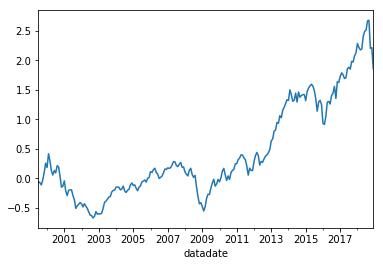

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.259198
2000-12-31   -0.309580
2001-12-31   -0.319539
2002-12-31   -0.333076
2003-12-31    1.032126
2004-12-31    0.151201
2005-12-31    0.100473
2006-12-31    0.134775
2007-12-31    0.036426
2008-12-31   -0.506770
2009-12-31    0.669833
2010-12-31    0.267647
2011-12-31   -0.091207
2012-12-31    0.314573
2013-12-31    0.567305
2014-12-31    0.036970
2015-12-31   -0.069736
2016-12-31    0.166192
2017-12-31    0.192075
2018-12-31   -0.087093
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     496.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.50e-111
Time:                        02:22:14   Log-Likelihood:                 534.07
No. Observations:                 234   AIC:                            -1058.
Df Residuals:                     229   BIC:                            -1041.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.002      2.002      0.046    5.43e-05       0.007
mktrf          1.1861      0.047     25.479      0.000       1.094       1.278
me             0.4799      0.054      8.861      0.000       0.373       0.587
ia            -0.0870      0.082     -1.057      0.292      -0.249       0.075
roe           -0.6553      0.070     -9.302      0.000      -0.794      -0.516
==============================================================================
Omnibus:                       17.127   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.737
Skew:                           0.266   Prob(JB):                     8.65e-10
Kurtosis:                       5.000   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     350.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.51e-96
Time:                        02:22:14   Log-Likelihood:                 534.07
No. Observations:                 234   AIC:                            -1058.
Df Residuals:                     229   BIC:                            -1041.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.002      1.642      0.101      -0.001       0.007
mktrf          1.1861      0.053     22.525      0.000       1.083       1.289
me             0.4799      0.049      9.830      0.000       0.384       0.576
ia            -0.0870      0.118     -0.740      0.459      -0.317       0.143
roe           -0.6553      0.119     -5.517      0.000      -0.888      -0.422
==============================================================================
Omnibus:                       17.127   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.737
Skew:                           0.266   Prob(JB):                     8.65e-10
Kurtosis:                       5.000   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     672.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.00e-125
Time:                        02:22:14   Log-Likelihood:                 534.07
No. Observations:                 234   AIC:                            -1058.
Df Residuals:                     229   BIC:                            -1041.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.002      1.699      0.089      -0.001       0.007
mktrf          1.1861      0.052     22.650      0.000       1.083       1.289
me             0.4799      0.049      9.765      0.000       0.384       0.576
ia            -0.0870      0.103     -0.846      0.397      -0.288       0.114
roe           -0.6553      0.122     -5.358      0.000      -0.895      -0.416
==============================================================================
Omnibus:                       17.127   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.737
Skew:                           0.266   Prob(JB):                     8.65e-10
Kurtosis:                       5.000   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     363.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.73e-106
Time:                        02:22:14   Log-Likelihood:                 525.34
No. Observations:                 234   AIC:                            -1039.
Df Residuals:                     228   BIC:                            -1018.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.002      1.806      0.072      -0.000       0.007
mktrf          1.2390      0.049     25.534      0.000       1.143       1.335
smb            0.4856      0.064      7.584      0.000       0.359       0.612
hml            0.1011      0.075      1.339      0.182      -0.048       0.250
rmw           -0.6458      0.085     -7.566      0.000      -0.814      -0.478
cma           -0.0579      0.108     -0.534      0.594      -0.272       0.156
==============================================================================
Omnibus:                       25.293   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.515
Skew:                           0.500   Prob(JB):                     3.24e-13
Kurtosis:                       5.213   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     174.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.11e-76
Time:                        02:22:14   Log-Likelihood:                 525.34
No. Observations:                 234   AIC:                            -1039.
Df Residuals:                     228   BIC:                            -1018.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.002      1.789      0.074      -0.000       0.007
mktrf          1.2390      0.051     24.460      0.000       1.140       1.338
smb            0.4856      0.069      7.045      0.000       0.350       0.621
hml            0.1011      0.115      0.879      0.379      -0.124       0.327
rmw           -0.6458      0.111     -5.829      0.000      -0.863      -0.429
cma           -0.0579      0.138     -0.420      0.675      -0.328       0.213
==============================================================================
Omnibus:                       25.293   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.515
Skew:                           0.500   Prob(JB):                     3.24e-13
Kurtosis:                       5.213   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     242.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.46e-89
Time:                        02:22:14   Log-Likelihood:                 525.34
No. Observations:                 234   AIC:                            -1039.
Df Residuals:                     228   BIC:                            -1018.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.002      1.905      0.057   -9.42e-05       0.007
mktrf          1.2390      0.050     24.824      0.000       1.141       1.337
smb            0.4856      0.070      6.900      0.000       0.348       0.624
hml            0.1011      0.097      1.047      0.295      -0.088       0.290
rmw           -0.6458      0.114     -5.645      0.000      -0.870      -0.422
cma           -0.0579      0.128     -0.452      0.651      -0.309       0.193
==============================================================================
Omnibus:                       25.293   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.515
Skew:                           0.500   Prob(JB):                     3.24e-13
Kurtosis:                       5.213   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     396.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.13e-101
Time:                        02:22:14   Log-Likelihood:                 510.80
No. Observations:                 234   AIC:                            -1012.
Df Residuals:                     229   BIC:                            -994.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.002      0.541      0.589      -0.003       0.005
mktrf          1.3175      0.047     27.829      0.000       1.224       1.411
smb            0.7397      0.059     12.517      0.000       0.623       0.856
hml           -0.0572      0.059     -0.975      0.331      -0.173       0.058
umd           -0.2045      0.039     -5.310      0.000      -0.280      -0.129
==============================================================================
Omnibus:                       15.370   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.217
Skew:                           0.402   Prob(JB):                     5.51e-06
Kurtosis:                       4.356   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     284.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.52e-87
Time:                        02:22:14   Log-Likelihood:                 510.80
No. Observations:                 234   AIC:                            -1012.
Df Residuals:                     229   BIC:                            -994.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.002      0.493      0.622      -0.003       0.005
mktrf          1.3175      0.050     26.505      0.000       1.220       1.415
smb            0.7397      0.065     11.321      0.000       0.612       0.868
hml           -0.0572      0.078     -0.738      0.460      -0.209       0.095
umd           -0.2045      0.067     -3.062      0.002      -0.335      -0.074
==============================================================================
Omnibus:                       15.370   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.217
Skew:                           0.402   Prob(JB):                     5.51e-06
Kurtosis:                       4.356   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     296.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.74e-89
Time:                        02:22:14   Log-Likelihood:                 510.80
No. Observations:                 234   AIC:                            -1012.
Df Residuals:                     229   BIC:                            -994.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.002      0.511      0.609      -0.003       0.005
mktrf          1.3175      0.050     26.327      0.000       1.219       1.416
smb            0.7397      0.060     12.312      0.000       0.622       0.857
hml           -0.0572      0.071     -0.808      0.419      -0.196       0.082
umd           -0.2045      0.065     -3.162      0.002      -0.331      -0.078
==============================================================================
Omnibus:                       15.370   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.217
Skew:                           0.402   Prob(JB):                     5.51e-06
Kurtosis:                       4.356   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     241.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.44e-55
Time:                        02:22:14   Log-Likelihood:                 252.77
No. Observations:                 120   AIC:                            -495.5
Df Residuals:                     115   BIC:                            -481.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.003      1.282      0.202      -0.002       0.009
mktrf          1.2615      0.078     16.273      0.000       1.108       1.415
me             0.4715      0.077      6.159      0.000       0.320       0.623
ia            -0.0969      0.120     -0.808      0.421      -0.334       0.141
roe           -0.5535      0.106     -5.216      0.000      -0.764      -0.343
==============================================================================
Omnibus:                        9.731   Durbin-Watson:                   2.199
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               15.651
Skew:                           0.347   Prob(JB):                     0.000399
Kurtosis:                       4.627   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     204.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.55e-51
Time:                        02:22:14   Log-Likelihood:                 252.77
No. Observations:                 120   AIC:                            -495.5
Df Residuals:                     115   BIC:                            -481.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.004      0.967      0.334      -0.004       0.011
mktrf          1.2615      0.085     14.907      0.000       1.096       1.427
me             0.4715      0.070      6.747      0.000       0.335       0.609
ia            -0.0969      0.162     -0.598      0.550      -0.415       0.221
roe           -0.5535      0.162     -3.420      0.001      -0.871      -0.236
==============================================================================
Omnibus:                        9.731   Durbin-Watson:                   2.199
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               15.651
Skew:                           0.347   Prob(JB):                     0.000399
Kurtosis:                       4.627   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     386.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.19e-65
Time:                        02:22:14   Log-Likelihood:                 252.77
No. Observations:                 120   AIC:                            -495.5
Df Residuals:                     115   BIC:                            -481.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.004      1.008      0.313      -0.003       0.011
mktrf          1.2615      0.078     16.117      0.000       1.108       1.415
me             0.4715      0.067      6.986      0.000       0.339       0.604
ia            -0.0969      0.142     -0.683      0.494      -0.375       0.181
roe           -0.5535      0.160     -3.453      0.001      -0.868      -0.239
==============================================================================
Omnibus:                        9.731   Durbin-Watson:                   2.199
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               15.651
Skew:                           0.347   Prob(JB):                     0.000399
Kurtosis:                       4.627   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     192.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.99e-54
Time:                        02:22:15   Log-Likelihood:                 253.21
No. Observations:                 120   AIC:                            -494.4
Df Residuals:                     114   BIC:                            -477.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0053      0.003      1.784      0.077      -0.001       0.011
mktrf          1.3452      0.082     16.446      0.000       1.183       1.507
smb            0.4746      0.093      5.123      0.000       0.291       0.658
hml            0.0192      0.114      0.170      0.866      -0.206       0.244
rmw           -0.5355      0.134     -4.000      0.000      -0.801      -0.270
cma           -0.0002      0.147     -0.002      0.999      -0.291       0.290
==============================================================================
Omnibus:                       10.951   Durbin-Watson:                   2.198
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               15.715
Skew:                           0.459   Prob(JB):                     0.000387
Kurtosis:                       4.516   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     119.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.05e-43
Time:                        02:22:15   Log-Likelihood:                 253.21
No. Observations:                 120   AIC:                            -494.4
Df Residuals:                     114   BIC:                            -477.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0053      0.003      1.614      0.107      -0.001       0.012
mktrf          1.3452      0.084     15.961      0.000       1.180       1.510
smb            0.4746      0.095      4.972      0.000       0.288       0.662
hml            0.0192      0.143      0.134      0.893      -0.261       0.300
rmw           -0.5355      0.163     -3.281      0.001      -0.855      -0.216
cma           -0.0002      0.144     -0.002      0.999      -0.283       0.282
==============================================================================
Omnibus:                       10.951   Durbin-Watson:                   2.198
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               15.715
Skew:                           0.459   Prob(JB):                     0.000387
Kurtosis:                       4.516   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     174.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.11e-51
Time:                        02:22:15   Log-Likelihood:                 253.21
No. Observations:                 120   AIC:                            -494.4
Df Residuals:                     114   BIC:                            -477.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0053      0.003      1.802      0.071      -0.000       0.011
mktrf          1.3452      0.073     18.374      0.000       1.202       1.489
smb            0.4746      0.092      5.164      0.000       0.294       0.655
hml            0.0192      0.117      0.164      0.869      -0.210       0.249
rmw           -0.5355      0.168     -3.194      0.001      -0.864      -0.207
cma           -0.0002      0.122     -0.002      0.998      -0.239       0.238
==============================================================================
Omnibus:                       10.951   Durbin-Watson:                   2.198
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               15.715
Skew:                           0.459   Prob(JB):                     0.000387
Kurtosis:                       4.516   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     224.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.32e-53
Time:                        02:22:15   Log-Likelihood:                 249.02
No. Observations:                 120   AIC:                            -488.0
Df Residuals:                     115   BIC:                            -474.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.003      0.987      0.326      -0.003       0.009
mktrf          1.4183      0.070     20.129      0.000       1.279       1.558
smb            0.7046      0.080      8.783      0.000       0.546       0.864
hml           -0.0984      0.080     -1.224      0.223      -0.258       0.061
umd           -0.1726      0.050     -3.484      0.001      -0.271      -0.074
==============================================================================
Omnibus:                        6.981   Durbin-Watson:                   2.175
Prob(Omnibus):                  0.030   Jarque-Bera (JB):                7.627
Skew:                           0.387   Prob(JB):                       0.0221
Kurtosis:                       3.963   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     201.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.79e-51
Time:                        02:22:15   Log-Likelihood:                 249.02
No. Observations:                 120   AIC:                            -488.0
Df Residuals:                     115   BIC:                            -474.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.003      0.853      0.394      -0.004       0.009
mktrf          1.4183      0.061     23.421      0.000       1.300       1.537
smb            0.7046      0.083      8.480      0.000       0.542       0.867
hml           -0.0984      0.094     -1.044      0.297      -0.283       0.086
umd           -0.1726      0.074     -2.328      0.020      -0.318      -0.027
==============================================================================
Omnibus:                        6.981   Durbin-Watson:                   2.175
Prob(Omnibus):                  0.030   Jarque-Bera (JB):                7.627
Skew:                           0.387   Prob(JB):                       0.0221
Kurtosis:                       3.963   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     295.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.67e-59
Time:                        02:22:15   Log-Likelihood:                 249.02
No. Observations:                 120   AIC:                            -488.0
Df Residuals:                     115   BIC:                            -474.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.003      0.908      0.364      -0.003       0.009
mktrf          1.4183      0.048     29.288      0.000       1.323       1.513
smb            0.7046      0.074      9.481      0.000       0.559       0.850
hml           -0.0984      0.083     -1.179      0.238      -0.262       0.065
umd           -0.1726      0.068     -2.523      0.012      -0.307      -0.039
==============================================================================
Omnibus:                        6.981   Durbin-Watson:                   2.175
Prob(Omnibus):                  0.030   Jarque-Bera (JB):                7.627
Skew:                           0.387   Prob(JB):                       0.0221
Kurtosis:                       3.963   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     277.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.65e-56
Time:                        02:22:15   Log-Likelihood:                 298.76
No. Observations:                 114   AIC:                            -587.5
Df Residuals:                     109   BIC:                            -573.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.002      2.278      0.025       0.001       0.008
mktrf          1.0940      0.053     20.671      0.000       0.989       1.199
me             0.5454      0.082      6.674      0.000       0.383       0.707
ia            -0.1145      0.113     -1.010      0.315      -0.339       0.110
roe           -0.8533      0.100     -8.568      0.000      -1.051      -0.656
==============================================================================
Omnibus:                        3.701   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.157   Jarque-Bera (JB):                3.704
Skew:                           0.430   Prob(JB):                        0.157
Kurtosis:                       2.799   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     348.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.92e-61
Time:                        02:22:15   Log-Likelihood:                 298.76
No. Observations:                 114   AIC:                            -587.5
Df Residuals:                     109   BIC:                            -573.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.001      3.189      0.001       0.002       0.007
mktrf          1.0940      0.044     25.054      0.000       1.008       1.180
me             0.5454      0.044     12.323      0.000       0.459       0.632
ia            -0.1145      0.108     -1.061      0.289      -0.326       0.097
roe           -0.8533      0.102     -8.356      0.000      -1.053      -0.653
==============================================================================
Omnibus:                        3.701   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.157   Jarque-Bera (JB):                3.704
Skew:                           0.430   Prob(JB):                        0.157
Kurtosis:                       2.799   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     448.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.11e-66
Time:                        02:22:15   Log-Likelihood:                 298.76
No. Observations:                 114   AIC:                            -587.5
Df Residuals:                     109   BIC:                            -573.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.001      3.530      0.000       0.002       0.006
mktrf          1.0940      0.041     26.751      0.000       1.014       1.174
me             0.5454      0.037     14.936      0.000       0.474       0.617
ia            -0.1145      0.109     -1.052      0.293      -0.328       0.099
roe           -0.8533      0.098     -8.694      0.000      -1.046      -0.661
==============================================================================
Omnibus:                        3.701   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.157   Jarque-Bera (JB):                3.704
Skew:                           0.430   Prob(JB):                        0.157
Kurtosis:                       2.799   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     164.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.87e-49
Time:                        02:22:15   Log-Likelihood:                 283.93
No. Observations:                 114   AIC:                            -555.9
Df Residuals:                     108   BIC:                            -539.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.002      0.968      0.335      -0.002       0.006
mktrf          1.1388      0.058     19.717      0.000       1.024       1.253
smb            0.5557      0.094      5.927      0.000       0.370       0.742
hml            0.1051      0.120      0.879      0.382      -0.132       0.342
rmw           -0.7632      0.146     -5.212      0.000      -1.053      -0.473
cma           -0.0225      0.186     -0.121      0.904      -0.391       0.346
==============================================================================
Omnibus:                        5.214   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.074   Jarque-Bera (JB):                5.046
Skew:                           0.345   Prob(JB):                       0.0802
Kurtosis:                       3.765   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     208.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.52e-54
Time:                        02:22:15   Log-Likelihood:                 283.93
No. Observations:                 114   AIC:                            -555.9
Df Residuals:                     108   BIC:                            -539.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.361      0.174      -0.001       0.005
mktrf          1.1388      0.048     23.803      0.000       1.045       1.233
smb            0.5557      0.072      7.677      0.000       0.414       0.698
hml            0.1051      0.134      0.783      0.434      -0.158       0.368
rmw           -0.7632      0.184     -4.148      0.000      -1.124      -0.403
cma           -0.0225      0.216     -0.104      0.917      -0.446       0.401
==============================================================================
Omnibus:                        5.214   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.074   Jarque-Bera (JB):                5.046
Skew:                           0.345   Prob(JB):                       0.0802
Kurtosis:                       3.765   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     309.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.57e-62
Time:                        02:22:15   Log-Likelihood:                 283.93
No. Observations:                 114   AIC:                            -555.9
Df Residuals:                     108   BIC:                            -539.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.444      0.149      -0.001       0.005
mktrf          1.1388      0.046     24.854      0.000       1.049       1.229
smb            0.5557      0.062      8.927      0.000       0.434       0.678
hml            0.1051      0.151      0.694      0.488      -0.192       0.402
rmw           -0.7632      0.181     -4.223      0.000      -1.117      -0.409
cma           -0.0225      0.245     -0.092      0.927      -0.504       0.459
==============================================================================
Omnibus:                        5.214   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.074   Jarque-Bera (JB):                5.046
Skew:                           0.345   Prob(JB):                       0.0802
Kurtosis:                       3.765   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     166.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.69e-45
Time:                        02:22:15   Log-Likelihood:                 273.02
No. Observations:                 114   AIC:                            -536.0
Df Residuals:                     109   BIC:                            -522.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.485      0.629      -0.003       0.006
mktrf          1.1746      0.063     18.686      0.000       1.050       1.299
smb            0.7247      0.098      7.394      0.000       0.530       0.919
hml            0.1449      0.101      1.436      0.154      -0.055       0.345
umd           -0.1893      0.076     -2.486      0.014      -0.340      -0.038
==============================================================================
Omnibus:                        7.255   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.027   Jarque-Bera (JB):               10.384
Skew:                           0.271   Prob(JB):                      0.00556
Kurtosis:                       4.375   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     191.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.65e-48
Time:                        02:22:15   Log-Likelihood:                 273.02
No. Observations:                 114   AIC:                            -536.0
Df Residuals:                     109   BIC:                            -522.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.670      0.503      -0.002       0.004
mktrf          1.1746      0.051     22.949      0.000       1.074       1.275
smb            0.7247      0.085      8.513      0.000       0.558       0.892
hml            0.1449      0.146      0.996      0.319      -0.140       0.430
umd           -0.1893      0.083     -2.279      0.023      -0.352      -0.027
==============================================================================
Omnibus:                        7.255   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.027   Jarque-Bera (JB):               10.384
Skew:                           0.271   Prob(JB):                      0.00556
Kurtosis:                       4.375   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     235.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.12e-52
Time:                        02:22:15   Log-Likelihood:                 273.02
No. Observations:                 114   AIC:                            -536.0
Df Residuals:                     109   BIC:                            -522.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.002      0.711      0.477      -0.002       0.004
mktrf          1.1746      0.045     26.027      0.000       1.086       1.263
smb            0.7247      0.069     10.454      0.000       0.589       0.861
hml            0.1449      0.150      0.963      0.335      -0.150       0.440
umd           -0.1893      0.078     -2.432      0.015      -0.342      -0.037
==============================================================================
Omnibus:                        7.255   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.027   Jarque-Bera (JB):               10.384
Skew:                           0.271   Prob(JB):                      0.00556
Kurtosis:                       4.375   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""